In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
rating_data = pd.read_csv('C:/Users/dbsgu/ratings.csv')
movie_data = pd.read_csv('C:/Users/dbsgu/movies.csv')

In [6]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(movie_data.shape)
print(rating_data.shape)

(9125, 3)
(100004, 4)


In [9]:
#전처리
rating_data.drop('timestamp', axis=1, inplace=True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [11]:
movie_data.drop('genres', axis=1, inplace=True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [13]:
user_movie_data = pd.merge(rating_data, movie_data, on='movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [14]:
user_movie_data.shape

(100004, 4)

In [15]:
#불필요한 column 제거 후 pandas의 merge를 이용해 하나로 합침
#pivot_table을 만들어준다. value에는 rating, column에는 movie title, index는 user id를 넣어준다.
user_movie_rating = user_movie_data.pivot_table('rating', index = 'userId', columns='title').fillna(0)

In [18]:
user_movie_rating.shape

(671, 9064)

In [19]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#사용자-영화 기준의 데이터를 영화-사용자 기준으로 만들어서 특정 영화와 비슷한 영화를 추천해주는 logic 구현
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(9064, 671)

In [21]:
type(movie_user_rating)

numpy.ndarray

In [22]:
#SVD사용
#scikit-learn에서 제공하는 truncated SVD는 SVD의 변형. 시그마 행렬의 특이값 가운데 상위 n개만 골라낸 것.
#이렇게 하면 기존 행렬 A의 성질과 거의 근사한 값이 나온다.
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [23]:
matrix[0]

array([ 0.01227491,  0.00250747,  0.0155477 , -0.03398923, -0.01448472,
        0.00366713, -0.00237928,  0.0450148 , -0.01596231, -0.02192016,
        0.01539217, -0.00852502])

In [26]:
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

In [27]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

<Axes: >

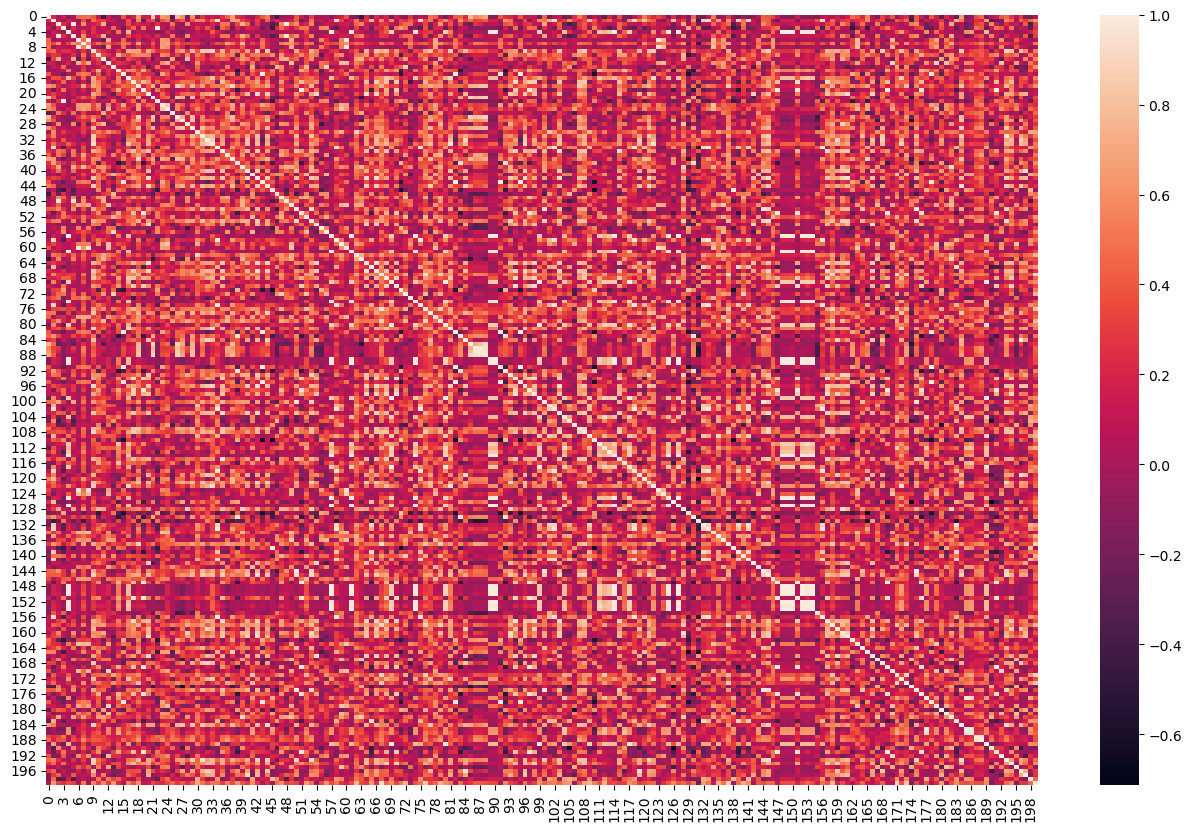

In [28]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)
#상관계수를 이용해서 특정 영화와 상관계수가 높은 영화를 추천해준다.

In [29]:
#하나의 영화에 대해서 비슷한 영화를 추천해주기
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Inception (2010)")

In [30]:
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:50]

['(500) Days of Summer (2009)',
 '12 Years a Slave (2013)',
 '127 Hours (2010)',
 '300 (2007)',
 'Alice in Wonderland (2010)',
 'Avatar (2009)',
 'Avengers, The (2012)',
 'Band of Brothers (2001)',
 'Batman: The Dark Knight Returns, Part 1 (2012)',
 'Battlestar Galactica (2003)',
 'Beowulf (2007)',
 'Black Mirror (2011)',
 'Black Swan (2010)',
 'Blood Diamond (2006)',
 'Book of Eli, The (2010)',
 'Bourne Ultimatum, The (2007)',
 'Bucket List, The (2007)',
 'Buried (2010)',
 'Cabin in the Woods, The (2012)',
 'Casino Royale (2006)',
 'Children of Men (2006)',
 'Click (2006)',
 'Coherence (2013)',
 'Crank: High Voltage (2009)',
 'Curious Case of Benjamin Button, The (2008)',
 'Dark Knight Rises, The (2012)',
 'Dark Knight, The (2008)',
 'Deadpool (2016)',
 'Departed, The (2006)',
 'District 9 (2009)',
 'Django Unchained (2012)',
 'Ex Machina (2015)',
 'Expendables, The (2010)',
 'Gone Girl (2014)',
 'Gran Torino (2008)',
 'Grand Budapest Hotel, The (2014)',
 'Gravity (2013)',
 'Grindhous

In [31]:
#보통 추천 시스템은 사용자에게 맞춤으로 추천을 해준다.
#때문에 사용자 맞춤 협업 필터링 행렬 분해를 적용하였다.
df_ratings = pd.read_csv('C:/Users/dbsgu/ratings.csv')
df_movies = pd.read_csv('C:/Users/dbsgu/movies.csv')

In [32]:
#앞서 했던 것과 똑같이 사용자-영화 pivot table 만듬
df_user_movie_ratings = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [33]:
df_user_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#pivot table을 matirx롤 변환 -> 사용자들이 매기는 평점의 평균을 구함 -> 사용자-평균 데이터값 변경
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
matrix = df_user_movie_ratings.to_numpy()

# user_ratings_mean은 사용자의 평균 평점 
user_ratings_mean = np.mean(matrix, axis = 1)

# R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [36]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [37]:
matrix.shape

(671, 9066)

In [38]:
user_ratings_mean.shape

(671,)

In [39]:
matrix_user_mean.shape

(671, 9066)

In [40]:
#초기에 만들었던 user-movie pivot table 값이 matrix_user_mean으로 변경됨
pd.DataFrame(matrix_user_mean, columns=df_user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,...,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128


In [41]:
#SVD를 이용해 Matrix Factorization 진행
#scipy를 이용해 truncated SVD를 구한다. scipy를 이용하면 u, sigma, vt 반환값들을 제공받을 수 있기 때문
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [43]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)
#이 시그마 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태이다.
#0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 한다.

(671, 12)
(12,)
(12, 9066)


In [44]:
sigma = np.diag(sigma)

In [45]:
sigma.shape

(12, 12)

In [46]:
sigma[0]

array([105.72437051,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [48]:
sigma[1]

#대칭 행렬로 변환 완료

array([  0.        , 110.15522471,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [49]:
#matrix_user_mean을 SVD를 적용해 분해한 상태이다 이제 다시 원본 행렬로 복구시켜야 한다.
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
# 거기에 + 사용자 평균 rating을 적용한다. 
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [50]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_movie_ratings.columns)
df_svd_preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.079686,0.021779,-0.013837,-0.005870,-0.028877,0.032371,0.000715,-0.004428,-0.005219,0.038195,...,-0.004324,-0.004352,0.010478,-0.004256,-0.003944,-0.005674,0.018157,-0.005575,-0.005297,-0.003766
1,1.428452,1.608841,0.529476,0.168278,0.520809,1.107473,0.529719,0.089376,0.296270,1.970031,...,0.013227,-0.002275,0.020680,-0.005245,-0.007644,-0.021019,0.031243,-0.000957,-0.000753,0.026901
2,0.977246,0.396971,0.000299,0.027444,0.021287,0.141458,-0.057134,0.031633,-0.012538,0.383576,...,0.002761,0.004907,-0.014190,-0.000251,-0.006007,-0.003189,-0.026916,0.014637,0.013287,-0.005741
3,1.870844,1.169993,0.252202,0.094831,-0.181713,-0.511953,-0.027820,-0.143080,0.013247,1.461694,...,0.026412,-0.027245,0.054681,0.018450,0.034544,-0.035740,0.088889,-0.019365,-0.017113,0.066559
4,1.182777,0.924903,0.075998,0.061505,0.602680,-0.159825,0.339925,0.081534,-0.079666,0.535018,...,-0.029124,-0.029357,0.009064,-0.029092,-0.030890,-0.057453,0.026344,-0.024027,-0.024614,-0.032752


In [51]:
df_svd_preds.shape

(671, 9066)

In [52]:
def recommend_movies(df_svd_preds, user_id, ori_movies_df, ori_ratings_df, num_recommendations=5):
    
    user_row_number = user_id - 1 
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬 됌
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.userId == user_id]
    
    # 위에서 뽑은 user_data와 원본 영화 데이터를 합친다. 
    user_history = user_data.merge(ori_movies_df, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출
    recommendations = ori_movies_df[~ori_movies_df['movieId'].isin(user_history['movieId'])]
    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = recommendations.merge( pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_history, recommendations

In [55]:
already_rated, predictions = recommend_movies(df_svd_preds, 330, df_movies, df_ratings, 10)

In [56]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
47,330,1094,5.0,948577200,"Crying Game, The (1992)",Drama|Romance|Thriller
14,330,213,5.0,948577039,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama
34,330,527,5.0,948577164,Schindler's List (1993),Drama|War
45,330,1035,5.0,948574126,"Sound of Music, The (1965)",Musical|Romance
48,330,1172,5.0,948575236,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
53,330,1249,5.0,948576522,"Femme Nikita, La (Nikita) (1990)",Action|Crime|Romance|Thriller
27,330,373,5.0,948576522,Red Rock West (1992),Thriller
58,330,1428,5.0,948731410,Angel Baby (1995),Drama
61,330,1575,5.0,948577442,Gabbeh (1996),Drama
67,330,1683,5.0,948578017,"Wings of the Dove, The (1997)",Drama|Romance


In [57]:
predictions

,movieId,title,genres,Predictions
246,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2.060064
294,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1.772814
497,608,Fargo (1996),Comedy|Crime|Drama|Thriller,1.526111
487,590,Dances with Wolves (1990),Adventure|Drama|Western,1.508960
316,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,1.276646
40,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1.265219
313,377,Speed (1994),Action|Romance|Thriller,1.142113
214,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1.076539
295,357,Four Weddings and a Funeral (1994),Comedy|Romance,1.065911
488,592,Batman (1989),Action|Crime|Thriller,1.048861
